In [2]:
import sys
sys.path.append("/home/149/ab8992/tasman-tides/")
import xarray as xr
import ttidelib as tt
import scipy
import cmocean
import os
from pathlib import Path
cmap = cmocean.cm.dense_r
import matplotlib
import matplotlib.pyplot as plt
earth_cmap = matplotlib.colormaps["gist_earth"]
from datetime import timedelta
import warnings
warnings.simplefilter("ignore")
# import filtering
import numpy as np
import dask
dask.config.set({'logging.distributed': 'error'})
from dask.distributed import Client,default_client
import xrft
import matplotlib.gridspec as gridspec

client = tt.startdask(nthreads=1,n_workers = 52)

client

<Client: 'tcp://127.0.0.1:36167' processes=52 threads=52, memory=416.00 GiB>


<Client: 'tcp://127.0.0.1:36167' processes=52 threads=52, memory=416.00 GiB>

# Mode 1 anomaly line plots below 3 panels of mode 1 propagation per resolution

In [3]:

data = {}
for expt in ["full-10","full-20","full-40","full-80"]:
# for expt in ["full-40","beamless-40","smooth-40"]:
    path = Path(f"/g/data/nm03/ab8992/postprocessed/figdata/energies") / expt
    bathy = xr.open_dataset(f"/g/data/nm03/ab8992/outputs/{expt}/bathy_transect.nc")
    times = os.listdir(path)
    times = np.sort(np.array([int(i.split("t0-")[1]) for i in times]))

    data[expt] = None
    for i in range(len(times)):
        try:
            newdata = xr.merge(
                        [
                            xr.open_dataset(path / f"t0-{times[i]}" / "EF_alongbeam.nc",decode_times= False,decode_cf = False).rename({"EF":"EF_alongbeam"}).mean("time").load(),
                            xr.open_dataset(path / f"t0-{times[i]}" / "EF_acrossbeam.nc",decode_times= False,decode_cf = False).rename({"EF":"EF_acrossbeam"}).mean("time").load(),
                            bathy.rename({"depth":"bathy"}) * -1
                        ]
                    ).expand_dims({"time":[float(times[i])]})
            if data[expt] is None:
                data[expt] = newdata
            else:
                data[expt] = xr.concat(
                    [
                        data[expt],
                        newdata
                    ],
                    dim = "time"
                )
        except Exception as e:
            print(f"Error processing time {times[i]} for experiment {expt}: {e}")

    data[expt] = data[expt].mean("time")
    # data[expt].time.values[:] /= 24


Error processing time 3960 for experiment full-40: [Errno 2] No such file or directory: '/g/data/nm03/ab8992/postprocessed/figdata/energies/full-40/t0-3960/EF_alongbeam.nc'


KeyboardInterrupt: 

In [10]:
data["full-80"] = xr.merge([
    xr.open_dataarray("/scratch/nm03/ab8992/april25/outputs/full-80/EF_alongbeam.nc").mean("time").rename("EF_alongbeam"),
    xr.open_dataarray("/scratch/nm03/ab8992/april25/outputs/full-80/EF_acrossbeam.nc").mean("time").rename("EF_acrossbeam"),
    xr.open_dataarray("/scratch/nm03/ab8992/april25/outputs/full-80/KE.nc")
])

# MODE 1 COMPARISON PLOTS

Have an along-beam anomaly 

         3.8 mW/m per m
         2.7 mW/m per m
         2.1 mW/m per m
         1.3 mW/m per m


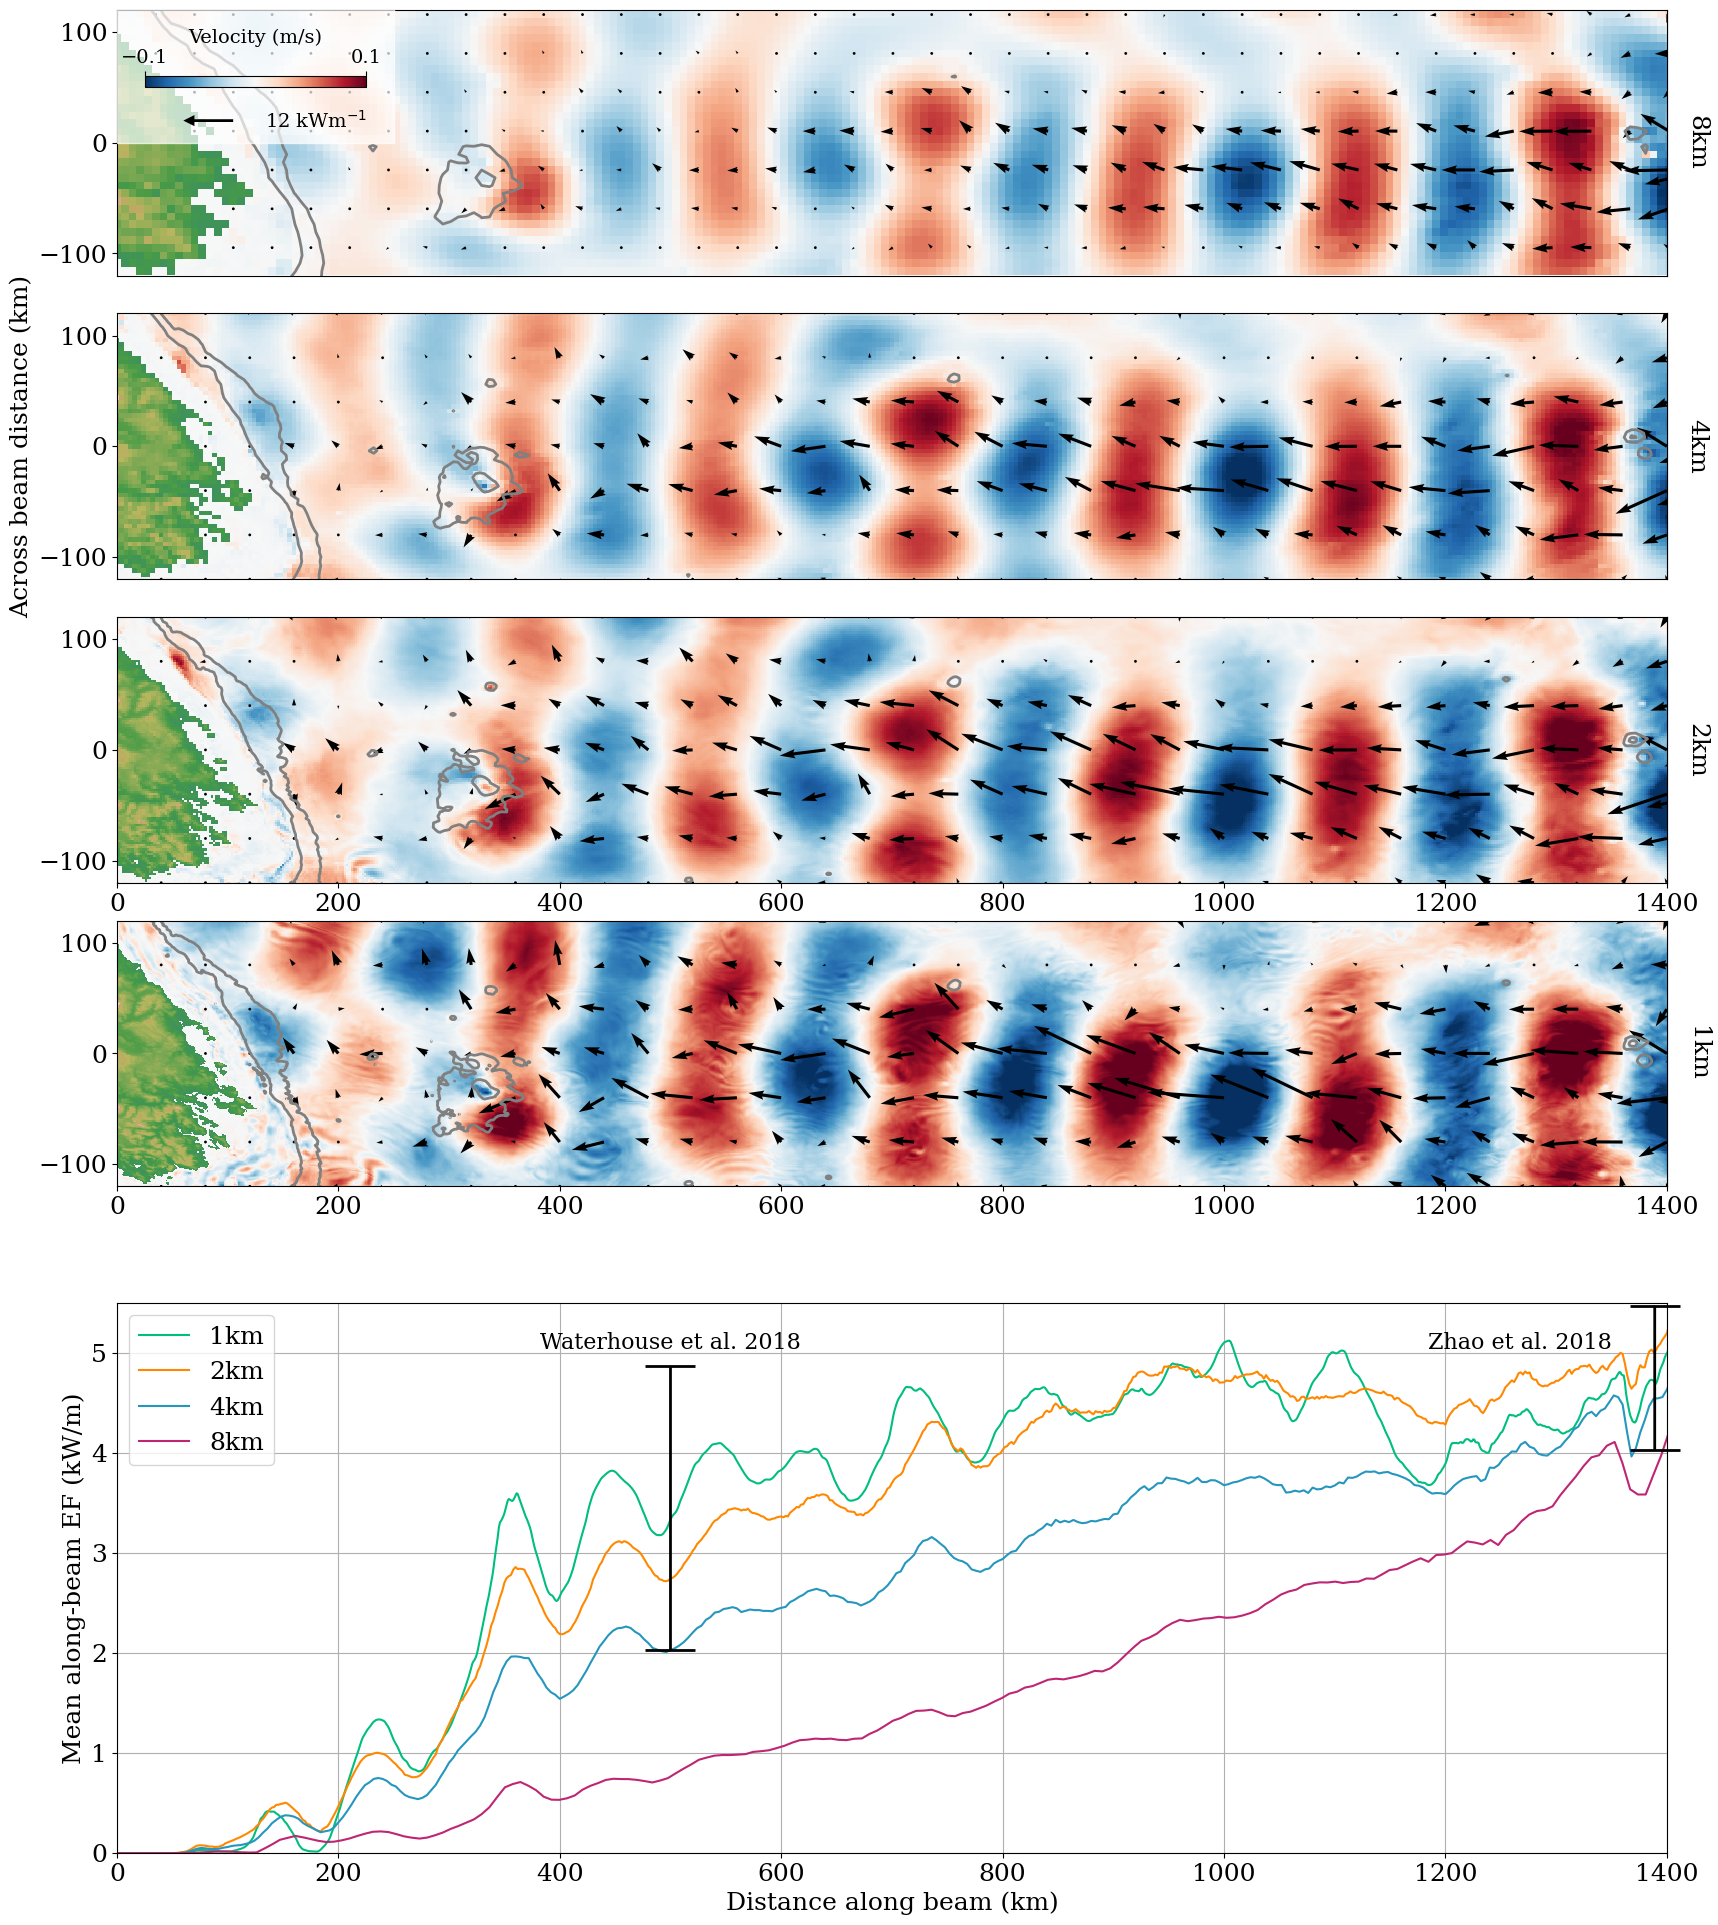

In [41]:

import matplotlib.gridspec as gridspec
font = {'family' : 'serif',
        'weight':'normal',
        'size'   : 18}
matplotlib.rc('font', **font)

def plot_KE_quiver(expt,ax,mode = 0,xlim = slice(None,None),ylim = slice(None,None),scale = 3000,umax = 1):
    # expt = "full-20"
    alongbeam = data[expt].EF_alongbeam
    acrossbeam = data[expt].EF_acrossbeam
    u = xr.open_mfdataset(f"/g/data/nm03/ab8992/postprocessed/figdata/snapshots/{expt}/u_*.nc").u.isel(mode = mode)
    t0 = 22000
    if "40" in expt:
        t0 = 4216
    if "80" in expt:
        t0 = 12258

    vmode = xr.open_dataset(f"/g/data/nm03/ab8992/postprocessed/{expt}/vertical_eigenfunctions/vmode-t0-{t0}.nc").U
    vmode = xr.open_dataset(f"/g/data/nm03/ab8992/postprocessed/full-40/vertical_eigenfunctions/vmode-t0-4216.nc").U

    u *= vmode.interp_like(u.isel(time = 0)).isel(mode = mode).sel(zl = 50,method = "nearest")

    alongbeam = alongbeam.sel(xb = xlim,yb = ylim).isel(mode = mode)
    acrossbeam = acrossbeam.sel(xb = xlim,yb = ylim).isel(mode = mode)

    if "mode" in alongbeam.dims:
        alongbeam = alongbeam.sum("mode")
        acrossbeam = acrossbeam.sum("mode")
    if "mode" in u.dims:
        u = u.sum("mode")

    # np.sqrt(acrossbeam**2 + alongbeam**2).sum("mode").plot(ax = ax)
    yspacing = 5
    xspacing = 5
    if "20" in expt:
        yspacing,xspacing = yspacing * 2, xspacing * 2
    elif "40" in expt:
        yspacing,xspacing = yspacing * 4, xspacing * 4
    elif "80" in expt:
        yspacing,xspacing = yspacing * 8, xspacing * 8
    _yb = acrossbeam.yb[::yspacing]
    _xb = acrossbeam.xb[::xspacing]
    _along = (alongbeam )[::yspacing,::xspacing]
    _across = (acrossbeam)[::yspacing,::xspacing]

    # print(expt,np.mean(magnitude.sel(xb = slice(100,175)).values),sep = "\t")
    t0 = 50
    if "40" in expt:
        t0 = 49 ## Correct phase for 40th so the y line up 
    elif "80" in expt:
        t0 = 18 ## back 5 from 20 
    u.isel(time = t0).plot(ax = ax,cmap ="RdBu",add_colorbar = False,vmax = umax,vmin = -1 * umax)
    # print(magnitude)
    ax.quiver(_xb, _yb, _along, _across, color="black", scale=scale,scale_units = "width",width = 0.002)
    tt.plot_topo(ax,xr.open_dataset(f"/g/data/nm03/ab8992/outputs/{expt}/bathy_transect.nc").depth * -1)

    # ax.set_ylim(-120,120)
    ax.set_xlim(0,None)
    ax.set_xlabel("")
    ax.set_ylabel("")

    
fig = plt.figure(figsize = (20,24))
gs = gridspec.GridSpec(6, 1, height_ratios=[1, 1, 1, 1,0.2,2],hspace = 0.1,wspace = 0.1)

ax = [fig.add_subplot(gs[i]) for i in range(4)]
ax = np.array(ax)
ax_lineplot = fig.add_subplot(gs[5])

umax = 0.1
scale = 250000

for i,expt in enumerate(["full-10","full-20","full-40","full-80"]):
    plot_KE_quiver(expt,ax[i],xlim = slice(0,None),ylim = slice(None,None),mode = 0,scale = scale,umax = umax)
    data[expt].bathy.plot.contour(ax = ax[i],levels = [-2700,-1500],colors = ["grey","grey"],linewidths = 2,linestyles = ["solid"])

for i,a in enumerate(ax.flatten()):
    a.set_title("")
    a.set_xlabel("")
    a.set_aspect("equal")
    if i < 2:
        a.set_xticks([])
    a.set_ylabel("")
    a.set_yticks([])

    b = a.secondary_yaxis('right')
    b.set_ylabel('')
    a.set_yticks([-100,0,100])
    b.set_yticks([])
    if i == 0:
        b.set_ylabel("8km",rotation = 270,labelpad = 30)
    elif i == 1:
        b.set_ylabel("4km",rotation = 270,labelpad = 30)
    elif i == 2:
        b.set_ylabel("2km",rotation = 270,labelpad = 30)
    elif i == 3:
        b.set_ylabel("1km",rotation = 270,labelpad = 30)
    a.set_ylim(-120,120)
    a.set_xlim(0,1400)


ax[0].set_title("")
ax[2].set_xlabel("Along beam distance (km)")
ax[1].set_ylabel("Along beam distance (km)")
ax[1].set_ylabel("Across beam distance (km)")

efmax = 12
## Add our legend
patch = ax[0].add_patch(matplotlib.patches.Rectangle((0, 0), 250, 230, color='white', alpha=0.7))
cax1 = ax[0].inset_axes([25, 50, 200, 10],transform=ax[0].transData)  # Adjust size and location
patch.set_zorder(9)
cax1.set_zorder(10)  # Bring the patch to the front
cbar = plt.colorbar(
    plt.cm.ScalarMappable(cmap="RdBu_r", norm=plt.Normalize(vmin=-1 * umax, vmax=umax)),
    cax=cax1,
    orientation='horizontal',
    location = "top",
    label = "Velocity (m/s)",
)
cbar.set_ticks([-umax,umax])

cax1.tick_params(labelsize=14, color="black", labelcolor="black")  # Set font size and color for colorbar ticks
cax1.xaxis.label.set_size(14)  # Set font size for colorbar label
cax1.xaxis.label.set_color("black")  # Set label color to black
ax[0].annotate('', xy=(60, 20), xytext=(105, 20),
            arrowprops=dict(facecolor="black", width=2, headwidth=8, headlength = 8, edgecolor="none")).set_zorder(12)
ax[0].text(180, 20, str(efmax) + r" kWm$^{-1}$", color = "black", fontsize = 14, ha = "center", va = "center").set_zorder(12)


lineplot_colours = ['#be2573','#2596be','#ff8800',"#00bf7c"]
m1_10 = (-1 * data[f"full-10"].EF_alongbeam).isel(mode = 0).sel(yb = slice(-80,80),xb = slice(0,None)).mean("yb") / 1000
m1_20 = (-1 * data[f"full-20"].EF_alongbeam).isel(mode = 0).sel(yb = slice(-80,80),xb = slice(0,None)).mean("yb") / 1000
m1_40 = (-1 * data[f"full-40"].EF_alongbeam).isel(mode = 0).sel(yb = slice(-80,80),xb = slice(0,None)).mean("yb") / 1000
m1_80 = (-1 * data[f"full-80"].EF_alongbeam).isel(mode = 0).sel(yb = slice(-80,80),xb = slice(0,None)).mean("yb") / 1000

# m1_10 = (-1 * data[f"full-10"].EF_alongbeam_forward + data[f"beamless-10"].EF_alongbeam_forward).isel(mode = 0).sel(yb = slice(-100,100),xb = slice(0,None)).mean("yb")
# m1_20 = (-1 * data[f"full-20"].EF_alongbeam_forward + data[f"beamless-20"].EF_alongbeam_forward).isel(mode = 0).sel(yb = slice(-100,100),xb = slice(0,None)).mean("yb")
# m1_40 = (-1 * data[f"full-40"].EF_alongbeam_forward + data[f"beamless-40"].EF_alongbeam_forward).isel(mode = 0).sel(yb = slice(-100,100),xb = slice(0,None)).mean("yb")

## Add lines of best fit to the along beam from 1400 through to 600 before Rise interactions

for i,d in enumerate([m1_10,m1_20,m1_40,m1_80]):
    d = d.sel(xb = slice(400,None))

    linregress_result = scipy.stats.linregress(d.xb.values, d.values) # initially as kW / m / km. Same as W/m per m
    print(f"{1000 * linregress_result.slope:>12.1f} mW/m per m")
    # ax_lineplot.plot(d.xb.values, linregress_result.intercept + linregress_result.slope * d.xb.values, color = lineplot_colours[i], linestyle = "--", linewidth = 2)
    




m1_80.plot(ax = ax_lineplot,label = "1km",color = lineplot_colours[3])
m1_40.plot(ax = ax_lineplot,label = "2km",color = lineplot_colours[2])
m1_20.plot(ax = ax_lineplot,label = "4km",color = lineplot_colours[1])
m1_10.plot(ax = ax_lineplot,label = "8km",color = lineplot_colours[0])
ax_lineplot.legend()
ax_lineplot.set_title("")
ax_lineplot.set_xlim(0,1400)
ax_lineplot.set_ylim(0,5.5)
ax_lineplot.set_ylabel("Mean along-beam EF (kW/m)")
ax_lineplot.set_xlabel("Distance along beam (km)")

## Plot the Waterhouse figures

ax_lineplot.annotate('', xy=(500, 3.4 - 1.4), xytext=(500, 3.4 + 1.5),transform=ax_lineplot.transData,
            arrowprops=dict(arrowstyle="|-|",color="black", lw=2,capstyle='butt',joinstyle='miter')).set_zorder(12)
ax_lineplot.text(500,5.1, "Waterhouse et al. 2018", ha='center', va='center', transform=ax_lineplot.transData, fontsize=16)
ax_lineplot.annotate('', xy=(1389, 4), xytext=(1389, 5.5),transform=ax_lineplot.transData,
            arrowprops=dict(arrowstyle="|-|",color="black", lw=2,capstyle='butt',joinstyle='miter')).set_zorder(12)
ax_lineplot.text(1350,5.1, "Zhao et al. 2018", ha='right', va='center', transform=ax_lineplot.transData, fontsize=16)

ax_lineplot.grid()


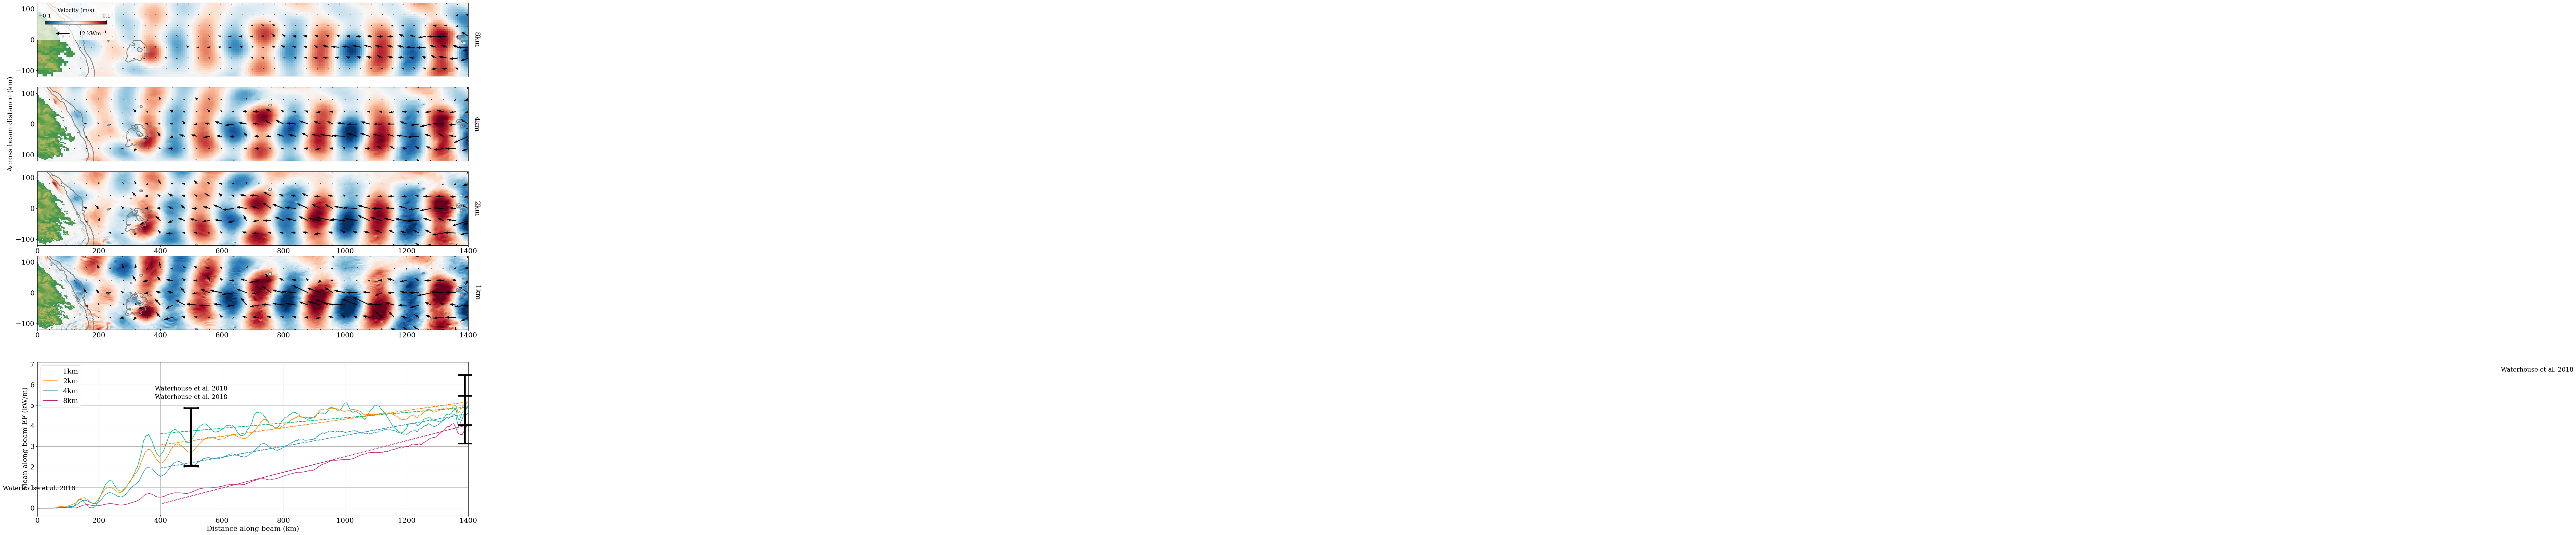

In [34]:
ax_lineplot.annotate('', xy=(500, 3.4 - 1.4), xytext=(500, 3.4 + 1.5),transform=ax_lineplot.transData,
            arrowprops=dict(arrowstyle="|-|",color="black", lw=4,capstyle='butt',joinstyle='miter')).set_zorder(12)
ax_lineplot.text(500,3.4 + 2, "Waterhouse et al. 2018", ha='center', va='center', transform=ax_lineplot.transData, fontsize=16)
ax_lineplot.annotate('', xy=(1389, 4), xytext=(1389, 5.5),transform=ax_lineplot.transData,
            arrowprops=dict(arrowstyle="|-|",color="black", lw=4,capstyle='butt',joinstyle='miter')).set_zorder(12)
ax_lineplot.grid()
fig

         3.8 W/m per m
         2.7 W/m per m
         2.1 W/m per m


Text(0.5, 1.0, 'Realistic, unfiltered (same as in paper)')

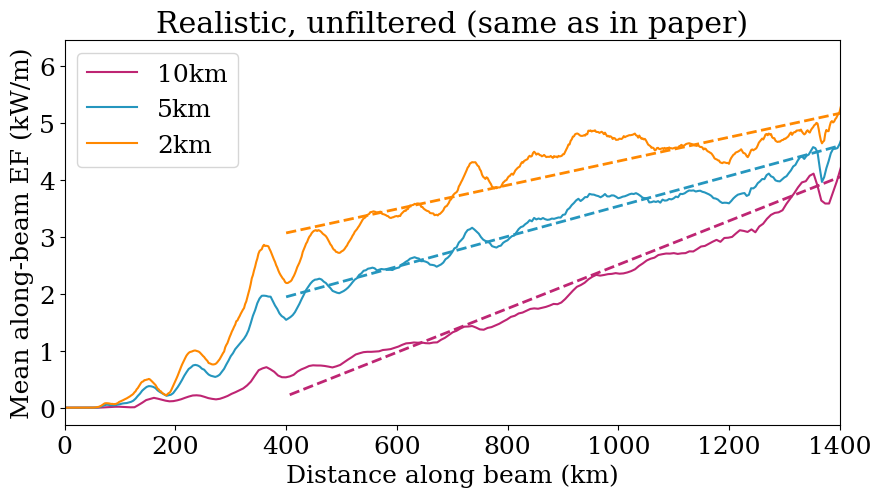

In [13]:
fig,ax_lineplot = plt.subplots(figsize=(10, 5))

lineplot_colours = ['#be2573','#2596be','#ff8800']
m1_10 = (-1 * data[f"full-10"].EF_alongbeam).isel(mode = 0).sel(yb = slice(-80,80),xb = slice(0,None)).mean("yb") / 1000
m1_20 = (-1 * data[f"full-20"].EF_alongbeam).isel(mode = 0).sel(yb = slice(-80,80),xb = slice(0,None)).mean("yb") / 1000
m1_40 = (-1 * data[f"full-40"].EF_alongbeam).isel(mode = 0).sel(yb = slice(-80,80),xb = slice(0,None)).mean("yb") / 1000
for i,d in enumerate([m1_10,m1_20,m1_40]):
    d = d.sel(xb = slice(400,None))

    linregress_result = scipy.stats.linregress(d.xb.values, d.values)
    print(f"{linregress_result.slope * 1000:>12.1f} W/m per m")
    ax_lineplot.plot(d.xb.values, linregress_result.intercept + linregress_result.slope * d.xb.values, color = lineplot_colours[i], linestyle = "--", linewidth = 2)


m1_10.plot(ax = ax_lineplot,label = "10km",color = lineplot_colours[0])
m1_20.plot(ax = ax_lineplot,label = "5km",color = lineplot_colours[1])
m1_40.plot(ax = ax_lineplot,label = "2km",color = lineplot_colours[2])
ax_lineplot.legend()
ax_lineplot.set_title("")
ax_lineplot.set_xlim(0,1400)
ax_lineplot.set_ylabel("Mean along-beam EF (kW/m)")
ax_lineplot.set_xlabel("Distance along beam (km)")
ax_lineplot.set_title("Realistic, unfiltered (same as in paper)")

         4.0 W/m per m
         2.6 W/m per m
         1.6 W/m per m


Text(0.5, 1.0, 'Smoothed, forward filtered')

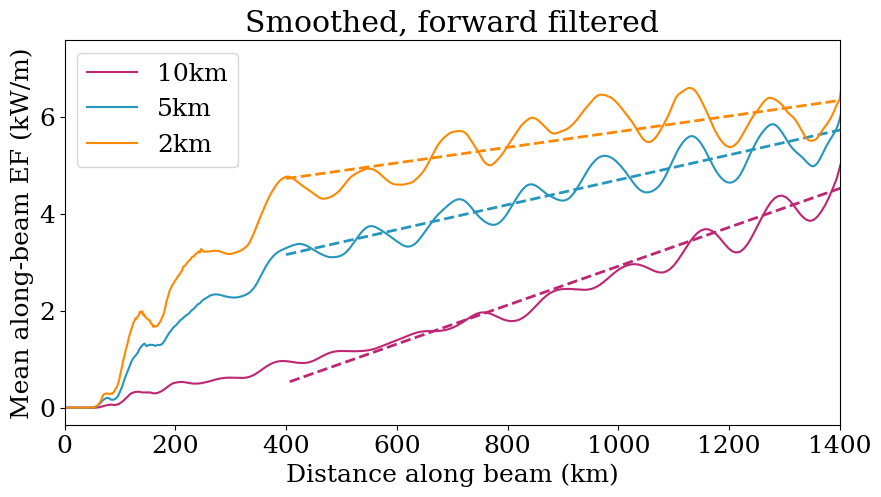

In [14]:
fig,ax_lineplot = plt.subplots(figsize=(10, 5))

lineplot_colours = ['#be2573','#2596be','#ff8800']
m1_10 = (-1 * data[f"smooth-10"].EF_alongbeam).isel(mode = 0).sel(yb = slice(-80,80),xb = slice(0,None)).mean("yb") / 1000
m1_20 = (-1 * data[f"smooth-20"].EF_alongbeam).isel(mode = 0).sel(yb = slice(-80,80),xb = slice(0,None)).mean("yb") / 1000
m1_40 = (-1 * data[f"smooth-40"].EF_alongbeam).isel(mode = 0).sel(yb = slice(-80,80),xb = slice(0,None)).mean("yb") / 1000
for i,d in enumerate([m1_10,m1_20,m1_40]):
    d = d.sel(xb = slice(400,None))

    linregress_result = scipy.stats.linregress(d.xb.values, d.values)
    print(f"{linregress_result.slope * 1000:>12.1f} W/m per m")
    ax_lineplot.plot(d.xb.values, linregress_result.intercept + linregress_result.slope * d.xb.values, color = lineplot_colours[i], linestyle = "--", linewidth = 2)


m1_10.plot(ax = ax_lineplot,label = "10km",color = lineplot_colours[0])
m1_20.plot(ax = ax_lineplot,label = "5km",color = lineplot_colours[1])
m1_40.plot(ax = ax_lineplot,label = "2km",color = lineplot_colours[2])
ax_lineplot.legend()
ax_lineplot.set_title("")
ax_lineplot.set_xlim(0,1400)
ax_lineplot.set_ylabel("Mean along-beam EF (kW/m)")
ax_lineplot.set_xlabel("Distance along beam (km)")
ax_lineplot.set_title("Smoothed, forward filtered")

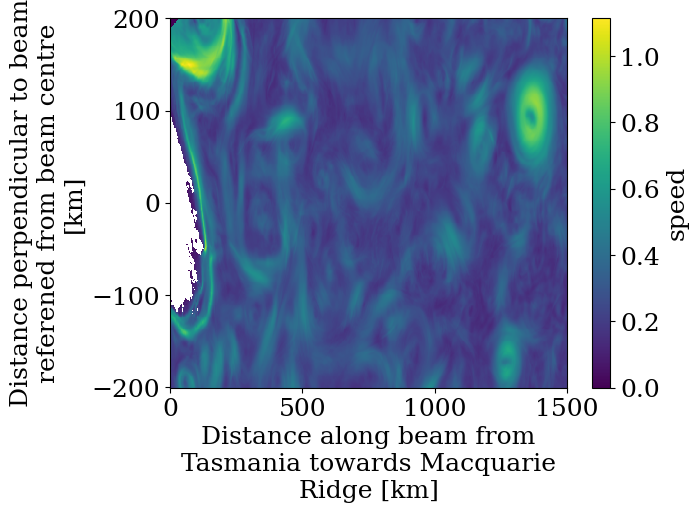

In [29]:
s = xr.open_mfdataset("/g/data/nm03/ab8992/outputs/beamless-80/output1*/surface_transect.nc").speed
s.mean("time").plot()


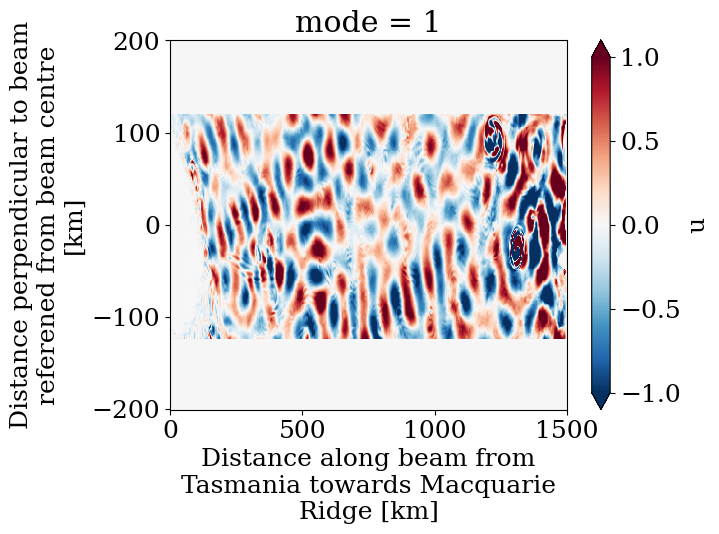

In [32]:
s = xr.open_mfdataset("/g/data/nm03/ab8992/postprocessed/figdata/snapshots/beamless-80/u_1.nc").u
s.isel(time = slice(50,55)).mean("time").plot(vmin = -1,vmax = 1,cmap = "RdBu_r")

(array([4.86832e+05, 3.44200e+03, 1.74200e+03, 8.71000e+02, 5.29000e+02,
        3.95000e+02, 2.99000e+02, 2.15000e+02, 1.29000e+02, 4.20000e+01]),
 array([0.        , 0.01808071, 0.03616142, 0.05424213, 0.07232284,
        0.09040355, 0.10848426, 0.12656496, 0.14464568, 0.16272639,
        0.1808071 ]),
 <BarContainer object of 10 artists>)

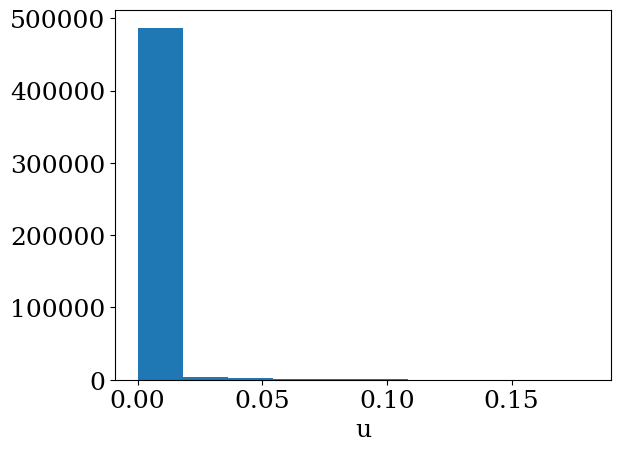

In [ ]:
s = xr.open_mfdataset("/g/data/nm03/ab8992/postprocessed/beamless-80/bandpassed/t0-12023/*.nc").u.sel(xb = slice(1250,1350),yb = slice(-50,0)).load().fillna(0)**2

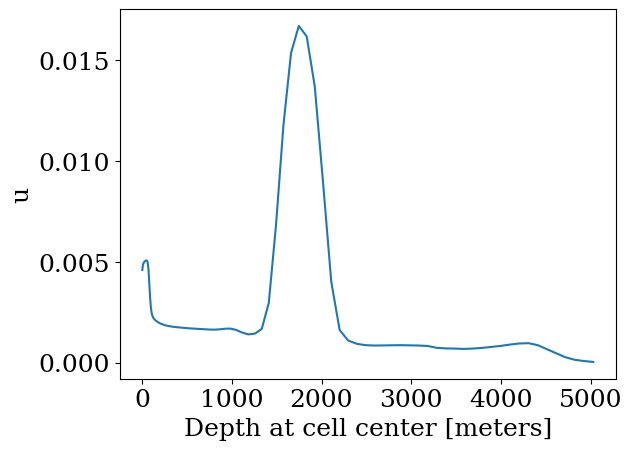

In [87]:
s.mean("time").mean("xb").mean("yb").plot()


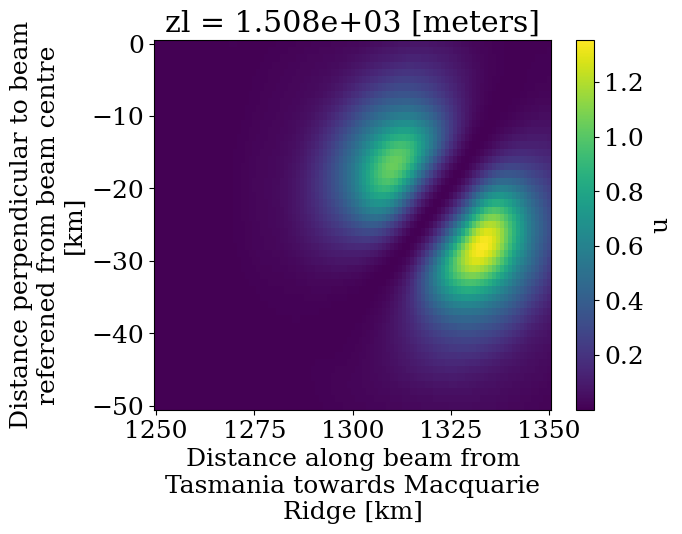

In [107]:
s = xr.open_mfdataset("/g/data/nm03/ab8992/outputs/beamless-80/output101/u/u*.nc").u.sel(xb = slice(1250,1350),yb = slice(-50,0)).load().fillna(0)**2
s.mean("time").isel(zl = 60).plot()

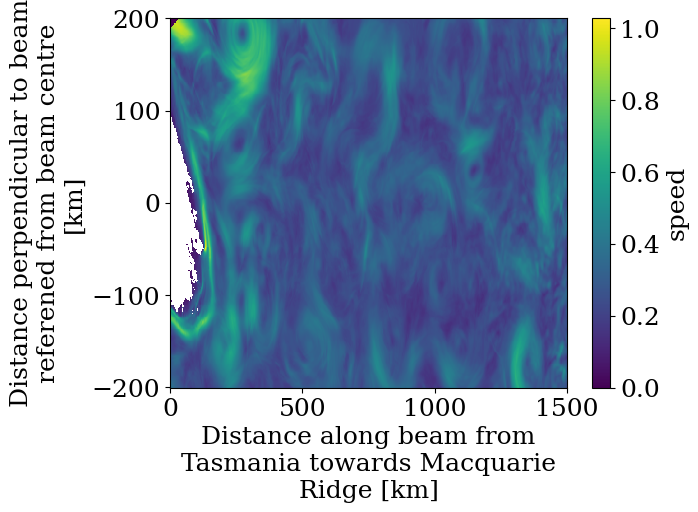

In [28]:
s = xr.open_mfdataset("/g/data/nm03/ab8992/outputs/full-80/output1*/surface_transect.nc").speed
s.mean("time").plot()

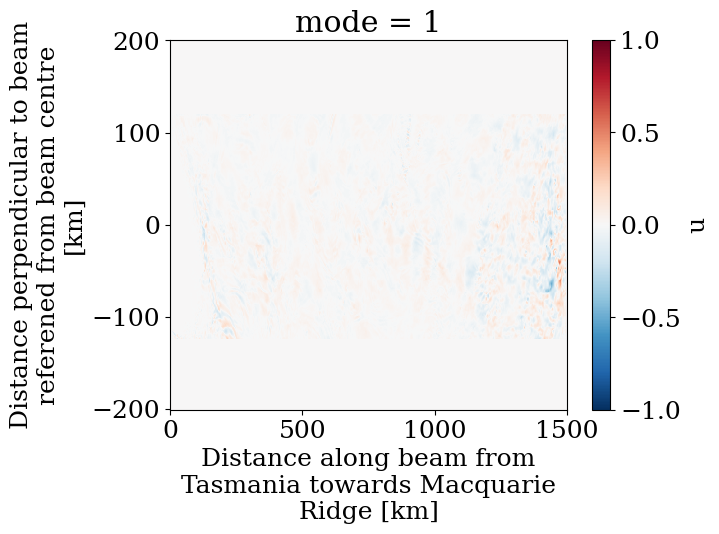

In [25]:
s = xr.open_mfdataset("/g/data/nm03/ab8992/postprocessed/figdata/snapshots/full-80/u_1.nc").u
s.isel(time = slice(20,None)).mean("time").plot(vmin = -1,vmax = 1,cmap = "RdBu_r")

All values are averages along the beam in W/m

res          fitted beam decay      actual beam decay    energy loss to N&S    decay + loss to NS 
10th              621.03               618.71                -119.07                 737.78 
20th              457.06               535.94                -172.15                 708.09 
40th              396.40               488.07                -137.81                 625.88 


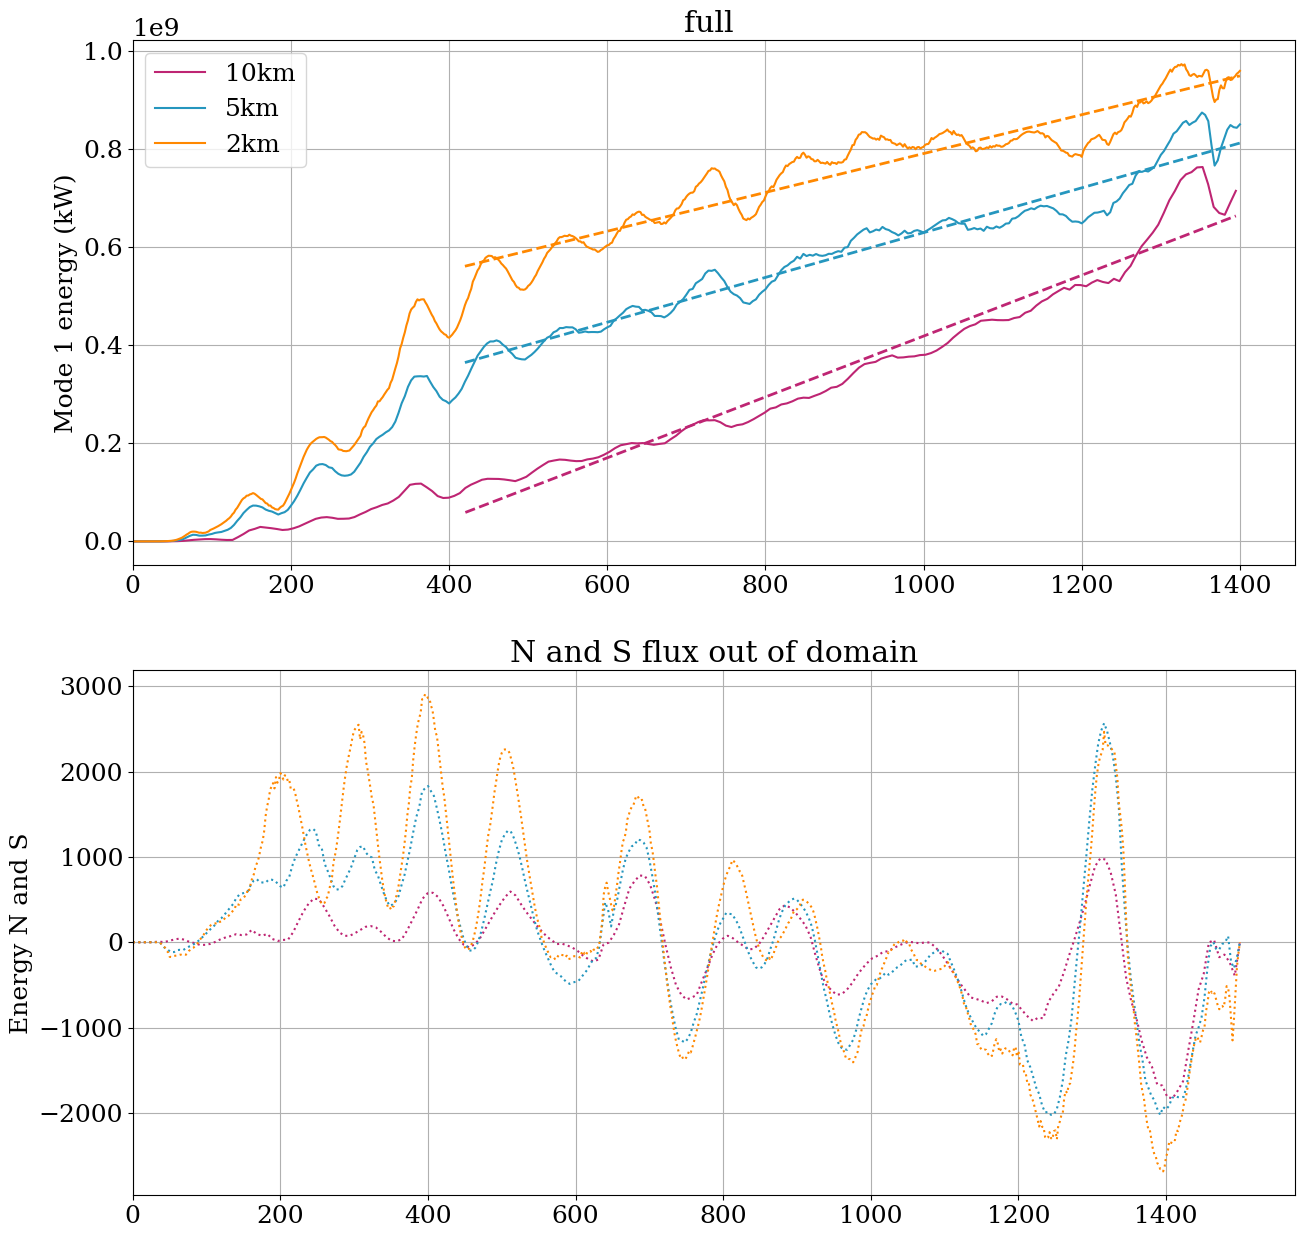

In [141]:
endpoint = 420
ybottom = -110
yextent = 110
startpoint = 1400
distance = (startpoint - endpoint) * 1000 # m


fig,ax_lineplot = plt.subplots(2,figsize=(15, 15))
expt = "full"
# filter = "_forward"
filter = ""
lineplot_colours = ['#be2573','#2596be','#ff8800']
m1_10_out =  (data[f"{expt}-10"][f"EF_acrossbeam{filter}"]).isel(mode = 0)  # W/m out
m1_20_out =  (data[f"{expt}-20"][f"EF_acrossbeam{filter}"]).isel(mode = 0) 
m1_40_out =  (data[f"{expt}-40"][f"EF_acrossbeam{filter}"]).isel(mode = 0) 
m1_10_out = - m1_10_out.sel(yb = ybottom,method = "nearest") + m1_10_out.sel(yb = yextent,method = "nearest") ## Energy out of domain in W / m
m1_20_out = - m1_20_out.sel(yb = ybottom,method = "nearest") + m1_20_out.sel(yb = yextent,method = "nearest")
m1_40_out = - m1_40_out.sel(yb = ybottom,method = "nearest") + m1_40_out.sel(yb = yextent,method = "nearest")
m1_10_along = (-1 * data[f"{expt}-10"][f"EF_alongbeam{filter}"]).isel(mode = 0).sel(yb = slice(ybottom,yextent),xb = slice(0,1400)).integrate("yb") * 1000  # W along beam  
m1_20_along = (-1 * data[f"{expt}-20"][f"EF_alongbeam{filter}"]).isel(mode = 0).sel(yb = slice(ybottom,yextent),xb = slice(0,1400)).integrate("yb") * 1000  # 
m1_40_along = (-1 * data[f"{expt}-40"][f"EF_alongbeam{filter}"]).isel(mode = 0).sel(yb = slice(ybottom,yextent),xb = slice(0,1400)).integrate("yb") * 1000  # 

print("All values are averages along the beam in W/m")
print("")
print(f"res        {'fitted beam decay ':>20}  {'actual beam decay':>20}  {'energy loss to N&S':>20}   {'decay + loss to NS ':>20}")
for i,d in enumerate([m1_10_along,m1_20_along,m1_40_along]):
    res = [10,20,40][i]
    d = d.sel(xb = slice(endpoint,startpoint))
    e_drop = (d.sel(xb = startpoint,method = "nearest") - d.sel(xb = endpoint,method = "nearest")) / distance # W / m average
    e_out = [m1_10_out,m1_20_out,m1_40_out][i].sel(xb = slice(endpoint,startpoint)).integrate("xb") * 1000 # total W out
    e_out /= distance # Convert to W/m
    linregress_result = scipy.stats.linregress(d.xb.values * 1000, d.values) # W / m 
    print(f"{res}th{linregress_result.slope:>20.2f} {e_drop:>20.2f}   {e_out.values:>20.2f}   {(e_drop - e_out):>20.2f} ")
    ax_lineplot[0].plot(d.xb.values, linregress_result.intercept + 1000 * linregress_result.slope * d.xb.values, color = lineplot_colours[i], linestyle = "--", linewidth = 2)

m1_10_out.plot(ax = ax_lineplot[1],color = lineplot_colours[0],alpha = 1,linestyle = "dotted")
m1_20_out.plot(ax = ax_lineplot[1],color = lineplot_colours[1],alpha = 1,linestyle = "dotted")
m1_40_out.plot(ax = ax_lineplot[1],color = lineplot_colours[2],alpha = 1,linestyle = "dotted")
m1_10_along.plot(ax = ax_lineplot[0],label = "10km",color = lineplot_colours[0])
m1_20_along.plot(ax = ax_lineplot[0],label = "5km",color = lineplot_colours[1])
m1_40_along.plot(ax = ax_lineplot[0],label = "2km",color = lineplot_colours[2])
ax_lineplot[0].legend()
ax_lineplot[0].set_title("Realistic topo along beam mode 1 energy")
ax_lineplot[0].set_xlim(0,None)
ax_lineplot[0].set_ylabel("Mode 1 energy (kW)")
ax_lineplot[0].set_xlabel("")
ax_lineplot[0].set_title(f"{expt} {filter}")

# ax_lineplot[1].legend()
ax_lineplot[1].set_title("")
ax_lineplot[1].set_xlim(0,None)
ax_lineplot[1].set_ylabel("Energy N and S")
ax_lineplot[1].set_xlabel("")
ax_lineplot[1].set_title(f"N and S flux out of domain")
ax_lineplot[0].grid()
ax_lineplot[1].grid()

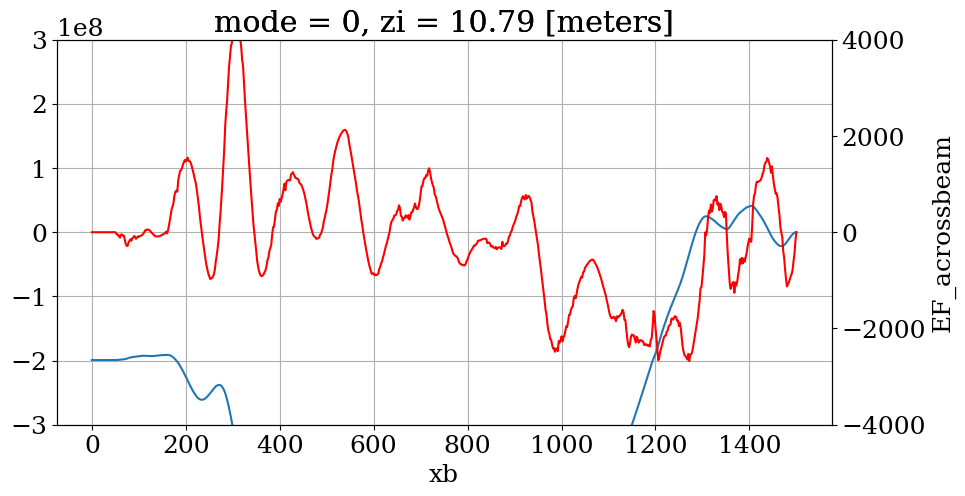

In [82]:
## Make a function that does a cumulative trapzoid integral along a specified axis
def cumulative_trapz_integral(data, axis=0):
    """
    Perform a cumulative trapezoidal integral along a specified axis.
    
    Parameters:
    - data: xarray DataArray or Dataset
    - axis: int, the axis along which to perform the integral
    
    Returns:
    - Cumulative integral as an xarray DataArray
    """
    out = scipy.integrate.cumulative_trapezoid(
        -1 * data.values[::-1], 
        x=data.xb.values[::-1] * 1000, 
        axis=axis, 
        initial=0
    )
    return xr.DataArray(
        out[::-1], 
        coords=data.coords, 
        dims=data.dims
    )

a = data["full-20"]
fig,ax = plt.subplots(1,figsize=(10, 5))
cumulative_trapz_integral(m1_40_out, axis=0).plot(ax = ax)
ax2 = ax.twinx()
m1_40_out.plot(ax = ax2,color = "red")
ax2.set_ylim(-4000,4000)
ax.set_ylim(-300000*1000,300000*1000)
ax.grid()

Text(0.5, 0, '')

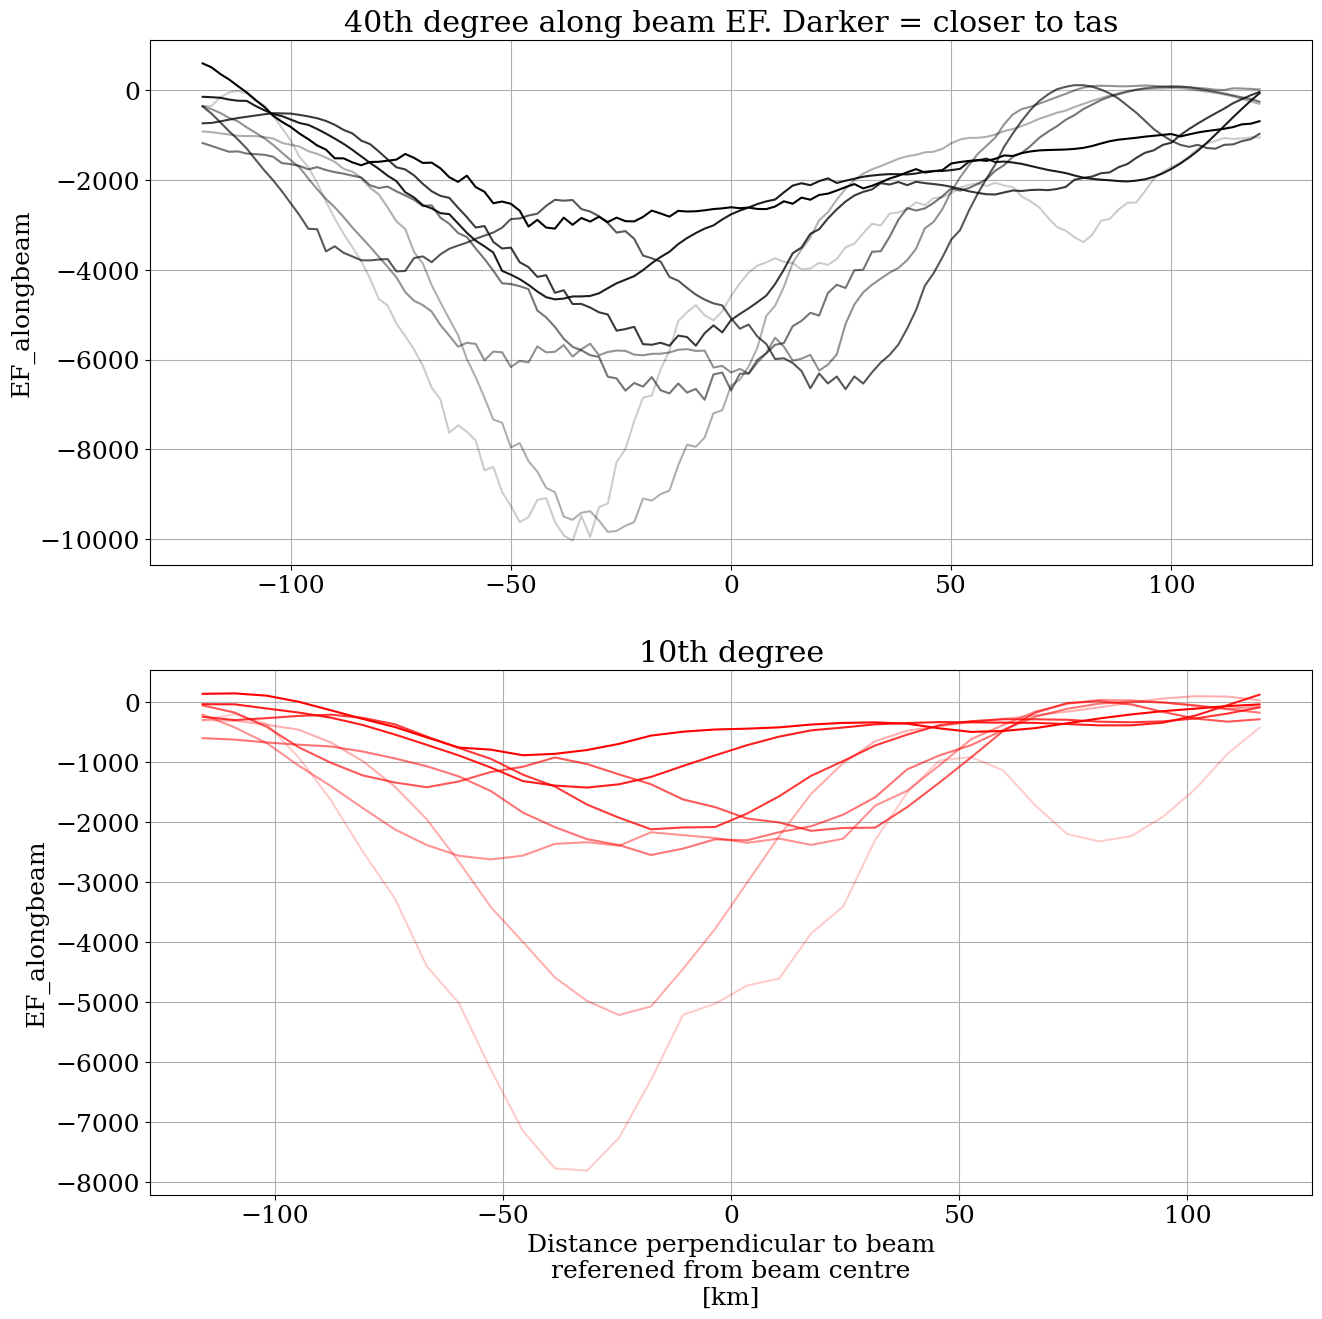

In [186]:
fig,ax = plt.subplots(2,figsize=(15, 15))

alphas = np.linspace(1, 0.2, 8)
for i,x in enumerate([400,500,600,700,800,900,1000,1400]):
    data["full-40"].EF_alongbeam.isel(mode = 0).sel(xb = x,method = "nearest").plot(label = "1000",ax = ax[0],color = "black",alpha = alphas[i])
    data["full-10"].EF_alongbeam.isel(mode = 0).sel(xb = x,method = "nearest").plot(label = "1000",ax = ax[1],color = "red",alpha = alphas[i])

ax[0].grid()
ax[1].grid()
ax[0].set_title("40th degree along beam EF. Darker = closer to tas")
ax[1].set_title("10th degree")
ax[0].set_xlabel("")

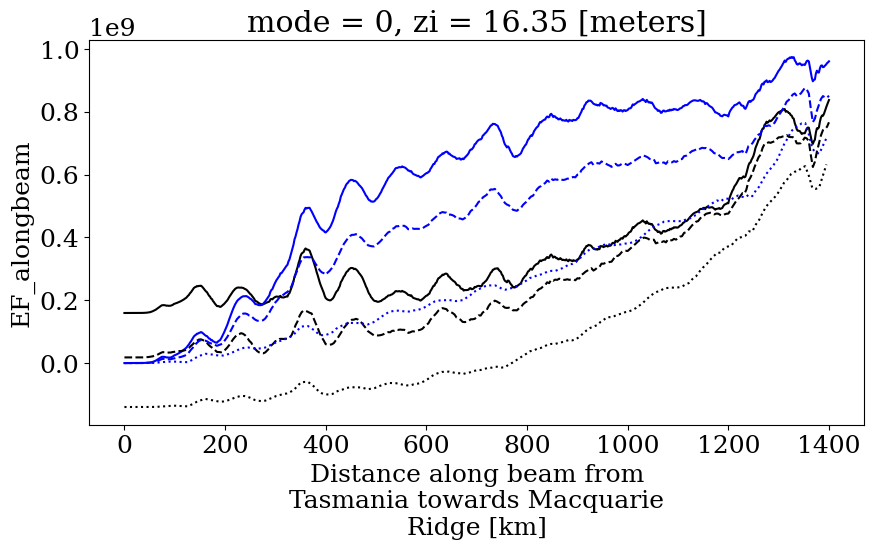

In [134]:
fig,ax = plt.subplots(1,figsize=(10, 5))

flux_in_40 = cumulative_trapz_integral(m1_40_out, axis=0)
(flux_in_40 + m1_40_along).plot(ax = ax,color = "black",label = "Total flux in")
(m1_40_along).plot(ax = ax,color = "blue",label = "Regular decay")

flux_in_20 = cumulative_trapz_integral(m1_20_out, axis=0)
(flux_in_20 + m1_20_along).plot(ax = ax,color = "black",label = "Total flux in",linestyle = "dashed")
(m1_20_along).plot(ax = ax,color = "blue",label = "Regular decay",linestyle = "dashed")

flux_in_10 = cumulative_trapz_integral(m1_10_out, axis=0)
(flux_in_10 + m1_10_along).plot(ax = ax,color = "black",label = "Total flux in",linestyle = "dotted")
(m1_10_along).plot(ax = ax,color = "blue",label = "Regular decay",linestyle = "dotted")

# ax.legend()

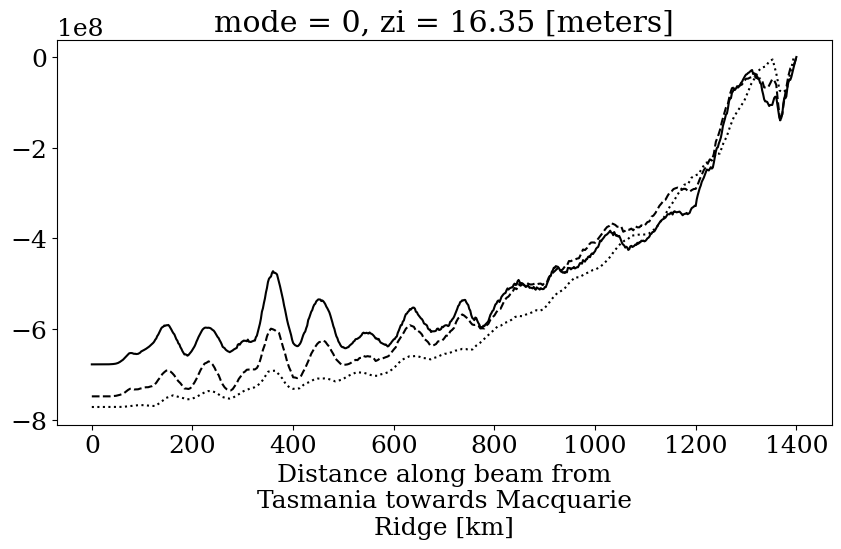

In [151]:
fig,ax = plt.subplots(1,figsize=(10, 5))

a40 = flux_in_40 + m1_40_along
a20 = flux_in_20 + m1_20_along
a10 = flux_in_10 + m1_10_along


(a40 - a40[-1] ).plot(ax = ax,color = "black",label = "Total flux in")
(a20 - a20[-1] ).plot(ax = ax,color = "black",label = "Total flux in",linestyle = "dashed")
(a10 - a10[-1] ).plot(ax = ax,color = "black",label = "Total flux in",linestyle = "dotted")


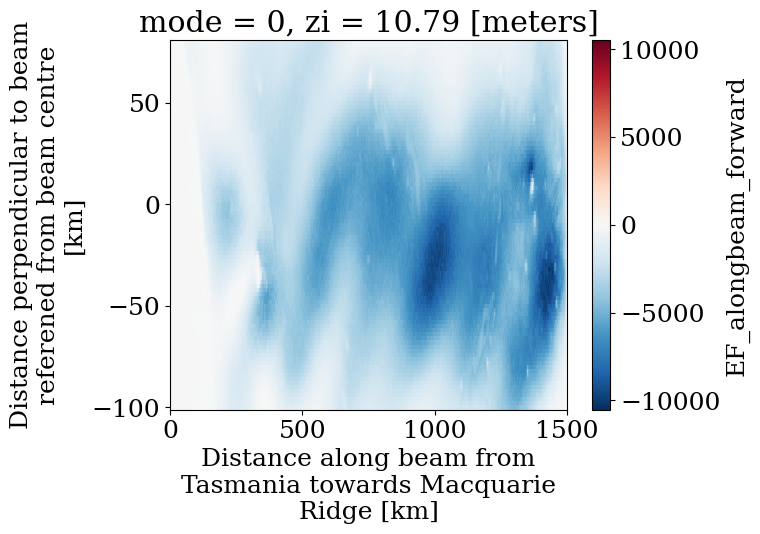

In [98]:
data["full-40"].EF_alongbeam_forward.isel(mode = 0).sel(yb = slice(-100,80)).plot()


In [161]:
yextent = 100

b = (data["full-40"] - data["beamless-40"]).isel(mode = 0)
a = (data["full-40"] - 0 * data["beamless-40"]).isel(mode = 0)
print((b.sel(yb = -yextent,method = "nearest") - b.sel(yb = yextent,method = "nearest")).EF_acrossbeam.sel(xb = slice(400,1400)).integrate("xb").values/1e3)
print((a.sel(yb = -yextent,method = "nearest") - a.sel(yb = yextent,method = "nearest")).EF_acrossbeam.sel(xb = slice(400,1400)).integrate("xb").values/1e3)

print((b.sel(xb = 400,method = "nearest") - b.sel(xb = 1400,method = "nearest")).EF_alongbeam.sel(yb = slice(-yextent,yextent)).integrate("yb").values / 1e3)
print((a.sel(xb = 400,method = "nearest") - a.sel(xb = 1400,method = "nearest")).EF_alongbeam.sel(yb = slice(-yextent,yextent)).integrate("yb").values / 1e3)


236.37195986270393
226.99893309156963
254.38930738977805
539.572404795654


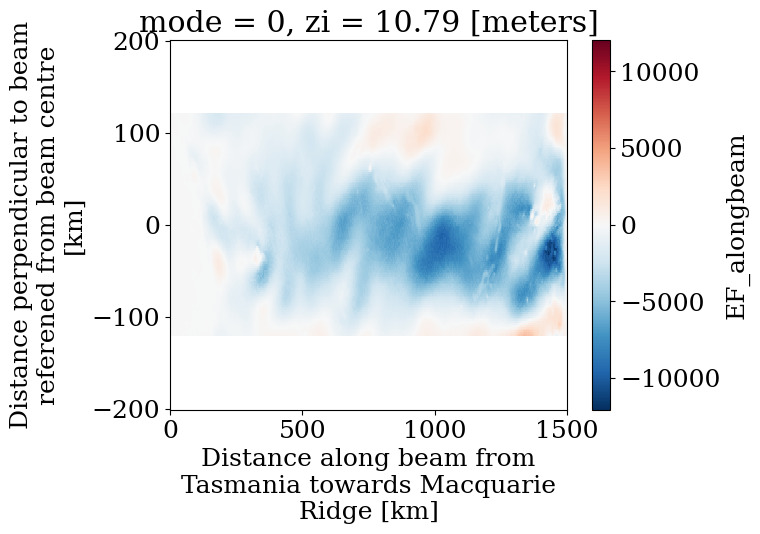

In [162]:
(data["full-40"] - data["beamless-40"]).EF_alongbeam.isel(mode = 0).plot()
